# 2024 인공지능 실습 1차시: Search

2024년 3월 28일 목요일

*   학번:2018131321
*   이름:김현우

* 제출 기한: 2024년 4월 4일 오후 2시 59분
* 이름 학번 필수 작성
* 금일 강의자료 제출 X
* 코랩 사용 시 제출 방법: 파일 > 다운로드 > .ipynb 형식으로 다운로드하여 제출

## 목차

1. Best-first search
2. Breadth-first search
3. Uniform-cost search
4. Depth-first search
5. Depth limited and Iterative deepening search
6. Greedy best-first search
7. A* search
8. Weighted A* search

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import heapq
import math
import sys
from collections import defaultdict, deque, Counter
from itertools import combinations

: 

# 1. Problem, Node, PriorityQueue Class

In [ ]:
class Problem(object):
    """The abstract class for a formal problem. A new domain subclasses this,
    overriding `actions` and `results`, and perhaps other methods.
    The default heuristic is 0 and the default action cost is 1 for all states.
    When yiou create an instance of a subclass, specify `initial`, and `goal` states
    (or give an `is_goal` method) and perhaps other keyword args for the subclass."""

    def __init__(self, initial=None, goal=None, **kwargs):
      """The constructor specifies the initial state, and possibly a goal
      state, if there is a unique goal. Your subclass's constructor can add
      other arguments."""
      self.__dict__.update(initial=initial, goal=goal, **kwargs)

    def actions(self, state):
      raise NotImplementedError

    def result(self, state, action):
      raise NotImplementedError

    def is_goal(self, state):
      return state == self.goal

    def action_cost(self, s, a, s1):
      return 1

    def h(self, node):
      return 0

    def __str__(self):
        return '{}({!r}, {!r})'.format(
            type(self).__name__, self.initial, self.goal)

: 

In [ ]:
class Problem(object):
    """The abstract class for a formal problem. A new domain subclasses this,
    overriding `actions` and `results`, and perhaps other methods.
    The default heuristic is 0 and the default action cost is 1 for all states.
    When yiou create an instance of a subclass, specify `initial`, and `goal` states
    (or give an `is_goal` method) and perhaps other keyword args for the subclass."""

    def __init__(self, initial=None, goal=None, **kwargs):
      """The constructor specifies the initial state, and possibly a goal
      state, if there is a unique goal. Your subclass's constructor can add
      other arguments."""
      self.__dict__.update(initial=initial, goal=goal, **kwargs)

    def actions(self, state):
      raise NotImplementedError

    def result(self, state, action):
      raise NotImplementedError

    def is_goal(self, state):
      return state == self.goal

    def action_cost(self, s, a, s1):
      return 1

    def h(self, node):
      return 0

    def __str__(self):
        return '{}({!r}, {!r})'.format(
            type(self).__name__, self.initial, self.goal)

: 

*   `__init__(self, initial, goal)` : 생성자(constructor)라고 불리며, 클래스의 객체(instance)를 생성할 때 처음 호출되는 메소드이다. 예를 들어 `Problem(initial, goal)`로 클래스의 객체를 만들 때 사용된다. 변수 initial은 탐색 문제의 초기 상태를 지정하며, start state을 나타낸다.

*   `actions(self, state)` : 주어진 상태에서 에이전트가 실행할 수 있는 모든 가능한 동작(액션)을 반환한다.

*   `result(self, state, action)` :  주어진 상태에서 주어진 동작을 실행했을 때의 결과 상태를 반환한다.

*   `is_goal(self, state)` : 주어진 상태가 goal state인지 여부를 판단하여 Boolean 값을 반환한다. Goal state인 경우 True를 반환하고, 그렇지 않은 경우 False를 반환한다.

*   `action_cost(self, s, a, s1)` : State s에서 action a를 취하여 state s1로 도달하는 경로의 비용을 반환한다.

*    `h(self, node)` : 주어진 노드에 대한 휴리스틱 값을 반환한다.

*   `__str__(self)` : 표준 파이썬 기능을 오버라이드하여 해당 클래스의 객체를 문자열로 표현한다.



In [ ]:
class Node:
    "A Node in a search tree."
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost

    def __repr__(self):
      return '<{}>'.format(self.state)

    def __len__(self):
      return 0 if self.parent is None else (1 + len(self.parent))

    def __lt__(self, other):
      return self.path_cost < other.path_cost

: 

*   `__init__(self, state, parent, action, path_cost)` : `Node` 클래스의 객체를 생성하는 생성자이다. `parent`는 현재 노드의 이전 노드를 나타내며, `action`은 부모 노드에서 현재 노드로 이동하는 데 필요한 행동이다. `path_cost`는 부모 노드로부터 현재 노드에 도달하는 비용이다.

*   `__repr__(self)` : 노드를 나타내는 문자열을 반환한다.

*   `__len__(self, other)` : 노드에서 부모 노드까지의 경로의 길이를 반환한다.

*   `__lt__(self, node)` : 현재 노드의 경로 비용이 다른 노드의 경로 비용보다 작은지 여부를 판단한다.

In [ ]:
failure = Node('failure', path_cost=math.inf) # Indicates an algorithm couldn't find a solution.
cutoff  = Node('cutoff',  path_cost=math.inf) # Indicates iterative deepening search was cut off.

def path_actions(node):
    "The sequence of actions to get to this node."
    if node.parent is None:
        return []
    return path_actions(node.parent) + [node.action]

def path_states(node):
    "The sequence of states to get to this node."
    if node in (cutoff, failure, None):
        return []
    return path_states(node.parent) + [node.state]

: 

In [ ]:
FIFOQueue = deque

LIFOQueue = list

class PriorityQueue:
    """A queue in which the item with minimum f(item) is always popped first."""

    def __init__(self, items=(), key=lambda x: x):
        self.key = key
        self.items = [] # a heap of (score, item) pairs
        for item in items:
            self.add(item)

    def add(self, item):
        """Add item to the queue."""
        pair = (self.key(item), item)
        heapq.heappush(self.items, pair)

    def pop(self):
        """Pop and return the item with min f(item) value."""
        return heapq.heappop(self.items)[1]

    def top(self):
      return self.items[0][1]

    def __len__(self):
      return len(self.items)

: 

# 2. RouteProblem

<img src='https://wikidocs.net/images/page/189097/Fig_03_01.PNG' width=700px>

In [ ]:
def straight_line_distance(A, B):
    "Straight-line distance between two points."
    return sum(abs(a - b)**2 for (a, b) in zip(A, B)) ** 0.5

: 

In [ ]:
class RouteProblem(Problem):
    """A problem to find a route between locations on a `Map`.
    Create a problem with RouteProblem(start, goal, map=Map(...)}).
    States are the vertexes in the Map graph; actions are destination states."""

    def __init__(self, initial=None, goal=None, **kwargs):
      super().__init__(initial=initial, goal=goal, **kwargs)

    def actions(self, state):
        """The places neighboring `state`."""
        return self.map.neighbors[state]

    def result(self, state, action):
        """Go to the `action` place, if the map says that is possible."""
        return action if action in self.map.neighbors[state] else state

    def action_cost(self, s, action, s1):
        """The distance (cost) to go from s to s1."""
        return self.map.distances[s, s1]

    def h(self, node):
        "Straight-line distance between state and the goal."
        locs = self.map.locations
        return straight_line_distance(locs[node.state], locs[self.goal])

: 

In [ ]:
class Map:
    """A map of places in a 2D world: a graph with vertexes and links between them.
    In `Map(links, locations)`, `links` can be either [(v1, v2)...] pairs,
    or a {(v1, v2): distance...} dict. Optional `locations` can be {v1: (x, y)}
    If `directed=False` then for every (v1, v2) link, we add a (v2, v1) link."""

    def __init__(self, links, locations=None, directed=False):
        if not hasattr(links, 'items'): # Distances are 1 by default
            links = {link: 1 for link in links}
        if not directed:
            for (v1, v2) in list(links):
                links[v2, v1] = links[v1, v2]
        self.distances = links
        self.neighbors = self.multimap(links)
        self.locations = locations or defaultdict(lambda: (0, 0))


    def multimap(self, pairs) -> dict:
        "Given (key, val) pairs, make a dict of {key: [val,...]}."
        result = defaultdict(list)
        for key, val in pairs:
            result[key].append(val)
        return result

: 

In [ ]:
romania = Map(
    {('O', 'Z'):  71, ('O', 'S'): 151, ('A', 'Z'): 75, ('A', 'S'): 140, ('A', 'T'): 118,
     ('L', 'T'): 111, ('L', 'M'):  70, ('D', 'M'): 75, ('C', 'D'): 120, ('C', 'R'): 146,
     ('C', 'P'): 138, ('R', 'S'):  80, ('F', 'S'): 99, ('B', 'F'): 211, ('B', 'P'): 101,
     ('B', 'G'):  90, ('B', 'U'):  85, ('H', 'U'): 98, ('E', 'H'):  86, ('U', 'V'): 142,
     ('I', 'V'):  92, ('I', 'N'):  87, ('P', 'R'): 97},
    {'A': ( 76, 497), 'B': (400, 327), 'C': (246, 285), 'D': (160, 296), 'E': (558, 294),
     'F': (285, 460), 'G': (368, 257), 'H': (548, 355), 'I': (488, 535), 'L': (162, 379),
     'M': (160, 343), 'N': (407, 561), 'O': (117, 580), 'P': (311, 372), 'R': (227, 412),
     'S': (187, 463), 'T': ( 83, 414), 'U': (471, 363), 'V': (535, 473), 'Z': (92, 539)})


r0 = RouteProblem('A', 'A', map=romania)
r1 = RouteProblem('A', 'B', map=romania)
r2 = RouteProblem('N', 'L', map=romania)
r3 = RouteProblem('E', 'T', map=romania)
r4 = RouteProblem('O', 'M', map=romania)

: 

In [ ]:
route = r1

: 

# 3. Uninformed Search Algorithms

## Best-first search

In [ ]:
def best_first_search(problem, f):
    global reached
    "Search nodes with minimum f(node) value first."
    node = Node(problem.initial)
    frontier = PriorityQueue([node], key=f)
    reached = {problem.initial: node}
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
    return failure

: 

In [ ]:
def expand(problem, node):
    "Expand a node, generating the children nodes."
    s = node.state
    for action in problem.actions(s):
        s1 = problem.result(s, action)
        cost = node.path_cost + problem.action_cost(s, action, s1)
        yield Node(s1, node, action, cost)

: 

## Breadth-first search

In [ ]:
def breadth_first_search(problem):
    "Search shallowest nodes in the search tree first."
    node = Node(problem.initial)
    if problem.is_goal(problem.initial):
        return node
    frontier = FIFOQueue([node])
    reached = {problem.initial}
    while frontier:
        node = frontier.pop()
        for child in expand(problem, node):  #먼저 발견한 S로 들어감
            s = child.state
            if problem.is_goal(s):
                return child
            if s not in reached:
                reached.add(s)
                frontier.appendleft(child)
    return failure

: 

In [ ]:
solution = breadth_first_search(route)
print(path_states(solution))
print(solution.path_cost)

: 

## Uniform-cost search

In [ ]:
def g(n): return n.path_cost

def uniform_cost_search(problem):
    "Search nodes with minimum path cost first."
    return best_first_search(problem, f=g)

: 

In [ ]:
solution = uniform_cost_search(route)
print(path_states(solution))
print('path cost: {:.1f}'.format(solution.path_cost))

: 

## Depth-first search

In [ ]:
def depth_first_bfs(problem):
    "Search deepest nodes in the search tree first; using best-first."
    return best_first_search(problem, f=lambda n: -len(n))

: 

In [ ]:
solution = depth_first_bfs(route)
print(path_states(solution))
print('path cost: {:.1f}'.format(solution.path_cost))

: 

## Depth-limited and Iterative deepening search

In [ ]:
def depth_limited_search(problem, limit=10):
    "Search deepest nodes in the search tree first."
    frontier = LIFOQueue([Node(problem.initial)])
    result = failure
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        elif len(node) >= limit:
            result = cutoff
        elif not is_cycle(node):
            for child in expand(problem, node):
                frontier.append(child)
    return result

: 

In [ ]:
def iterative_deepening_search(problem):
    "Do depth-limited search with increasing depth limits."
    for limit in range(1, sys.maxsize):
        result = depth_limited_search(problem, limit)
        if result != cutoff:
            return result

: 

*   *depth*: `sys.maxsize`

In [ ]:
def is_cycle(node, k=30):
    "Does this node form a cycle of length k or less?"
    def find_cycle(ancestor, k):
        return (ancestor is not None and k > 0 and
                (ancestor.state == node.state or find_cycle(ancestor.parent, k - 1)))
    return find_cycle(node.parent, k)

: 

In [ ]:
solution = depth_limited_search(route)
print(path_states(solution))
print('path cost: {:.1f}'.format(solution.path_cost))

: 

In [ ]:
solution = iterative_deepening_search(route)
print(path_states(solution))
print('path cost: {:.1f}'.format(solution.path_cost))

: 

# 4. Informed search algorithms

## Greedy best-first search

In [ ]:
def greedy_bfs(problem, h=None):
    """Search nodes with minimum h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=h)

: 

In [ ]:
solution = greedy_bfs(route)
print(path_states(solution))
print('path cost: {:.1f}'.format(solution.path_cost))

: 

## A* search

In [ ]:
def astar_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda n: g(n) + h(n))

: 

In [ ]:
solution = astar_search(route)
print(path_states(solution))
print('path cost: {:.1f}'.format(solution.path_cost))

: 

## Weighted A* search

In [ ]:
def weighted_astar_search(problem, h=None, weight = 2): #
    """Search nodes with minimum f(n) = g(n) + weight * h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda n: g(n) + weight + h(n))

: 

In [ ]:
solution = weighted_astar_search(route)  #과제할때 route, weight=2 이런식으로 파라미터 따로 지정
print(path_states(solution))
print('path cost: {:.1f}'.format(solution.path_cost))

: 

# 5. Reporting Summary Statistics on Search Algorithms

In [ ]:
class CountCalls:
    """Delegate all attribute gets to the object, and count them in ._counts"""
    def __init__(self, obj):
        self._object = obj
        self._counts = Counter()

    def __getattr__(self, attr):
        "Delegate to the original object, after incrementing a counter."
        self._counts[attr] += 1
        return getattr(self._object, attr)


def report(searchers, problems, verbose=True):
    """Show summary statistics for each searcher (and on each problem unless verbose is false)."""
    for searcher in searchers:
        print(searcher.__name__ + ':')
        total_counts = Counter()
        for p in problems:
            prob   = CountCalls(p)
            soln   = searcher(prob)
            counts = prob._counts;
            counts.update(actions=len(soln), cost=soln.path_cost)
            total_counts += counts
            if verbose: report_counts(counts, str(p)[:40])
        report_counts(total_counts, 'TOTAL\n')

def report_counts(counts, name):
    """Print one line of the counts report."""
    print('{:9,d} nodes |{:9,d} goal |{:5.0f} cost |{:8,d} actions | {}'.format(
          counts['result'], counts['is_goal'], counts['cost'], counts['actions'], name))

: 

*   Search algorithms: `breadth_first_search, uniform_cost_search, depth_first_bfs, iterative_deepening_search, depth_limited_search, greedy_bfs, astar_search, weighted_astar_search`
*   RouteProblems: `r1, r2, r3, r4`



In [ ]:
report([breadth_first_search, uniform_cost_search, depth_first_bfs,
        iterative_deepening_search, depth_limited_search, greedy_bfs, astar_search,
        weighted_astar_search], [r1, r2, r3, r4])

: 

# 6. GridProblem: Comparing reached states

In [ ]:
class GridProblem(Problem):
    """Finding a path on a 2D grid with obstacles. Obstacles are (x, y) cells."""

    def __init__(self, initial=(15, 30), goal=(130, 30), obstacles=(), **kwargs):
        Problem.__init__(self, initial=initial, goal=goal,
                         obstacles=set(obstacles) - {initial, goal}, **kwargs)

        self.directions = [(-1, -1), (0, -1), (1, -1),
                           (-1, 0),           (1,  0),
                           (-1, +1), (0, +1), (1, +1)]

    def action_cost(self, s, action, s1):
      return straight_line_distance(s, s1)

    def h(self, node):
      return straight_line_distance(node.state, self.goal)

    def result(self, state, action):
        "Both states and actions are represented by (x, y) pairs."
        return action if action not in self.obstacles else state

    def actions(self, state):
        """You can move one cell in any of `directions` to a non-obstacle cell."""
        x, y = state
        return {(x + dx, y + dy) for (dx, dy) in self.directions} - self.obstacles

: 

In [ ]:
def random_lines(X=range(15, 130), Y=range(60), N=150, lengths=range(6, 12)):
    """The set of cells in N random lines of the given lengths."""
    result = set()
    for _ in range(N):
        x, y = random.choice(X), random.choice(Y)
        dx, dy = random.choice(((0, 1), (1, 0)))
        result |= line(x, y, dx, dy, random.choice(lengths))
    return result

def line(x, y, dx, dy, length):
    """A line of `length` cells starting at (x, y) and going in (dx, dy) direction."""
    return {(x + i * dx, y + i * dy) for i in range(length)}

: 

In [ ]:
def plot_grid_problem(grid, solution, reached, title='Search'):
    """
    Use matplotlib to plot the grid, obstacles, solution, and reached.
    """
    plt.figure(figsize=(16, 10))
    plt.axis('off'); plt.axis('equal')
    plt.scatter(*transpose(grid.obstacles), marker='s', color='darkgrey')
    plt.scatter(*transpose([grid.initial]), 9**2, marker='D', c='green')
    plt.scatter(*transpose([grid.goal]), 9**2, marker='8', c='red')
    if solution != None:
      plt.scatter(*transpose(path_states(solution)), marker='s', c='blue')
      print('{} search: {:.1f} path cost'.format(title, solution.path_cost))
    if reached != None:
      reached = list(reached)
      plt.scatter(*transpose(reached), 1**2, marker='.', c='blue')
      print('{:,d} states reached'.format(len(reached)))
    plt.show()

def transpose(matrix): return list(zip(*matrix))

: 

In [ ]:
random.seed(42) # To make this reproducible

frame = line(-10, 20, 0, 1, 20) | line(150, 20, 0, 1, 20)
cup = line(102, 44, -1, 0, 15) | line(102, 20, -1, 0, 20) | line(102, 44, 0, -1, 24)

d1 = GridProblem(obstacles=random_lines(N=100) | frame)
d2 = GridProblem(obstacles=random_lines(N=150) | frame)
d3 = GridProblem(obstacles=random_lines(N=200) | frame)
d4 = GridProblem(obstacles=random_lines(N=250) | frame)
d5 = GridProblem(obstacles=random_lines(N=300) | frame)
d6 = GridProblem(obstacles=cup | frame)
d7 = GridProblem(obstacles=cup | frame | line(50, 35, 0, -1, 10) | line(60, 37, 0, -1, 17) | line(70, 31, 0, -1, 19))

: 

In [ ]:
plot_grid_problem(d3, solution=None, reached=None)

: 

위의 `best_first_search` 함수에서 `reached` 변수 `global`로 변경 후 아래 알고리즘의 결과 시각화:

*   `uniform_cost_search`
*   `greedy_bfs`
*   `astar_search`
*   `weighted_astar_search`


In [ ]:
solution = uniform_cost_search(d3)
plot_grid_problem(d3, solution, reached=None, title='Uniform cost search')

: 

In [ ]:
solution = greedy_bfs(d7)
plot_grid_problem(d7, solution, reached, 'Greedy BFS')

: 

In [ ]:
solution = astar_search(d7)
plot_grid_problem(d7, solution, reached, 'A* search')

: 

In [ ]:
solution = uniform_cost_search(d6)
plot_grid_problem(d6, solution, reached, 'weighted_astar_search')

: 

# 실습 과제

### 1번

아래 상황에 대한 problem formulation(initial state, goal test, successor function, cost function)을 텍스트로 작성하시오. 실제 구현을 할 수 있을 정도로 구체적으로 작성하시오.

1.   n × n 개의 정사각형 격자가 있으며, 각 정사각형은 처음에는 칠하지 않은 바닥이거나 바닥이 없는 구덩이이다. 칠하지 않은 바닥 정사각형에서 시작하며, 아래에 있는 정사각형을 칠하거나 인접한 칠하지 않은 바닥 정사각형으로 이동할 수 있다. 바닥 전체를 칠해야 한다.
2.   12리터, 8리터, 3리터으로 측정되는 3개의 주전자와 수도꼭지가 있다. 주전자들을 가득 채우거나 이것들을 하나에서 다른 것으로 비울 수 있다. 정확히 1리터을 측정하고자 한다.

1.n x n 2차원 배열, painted(칠해진 상태), unpainted(칠해지지 않은 상태), hole(구덩이)로 구분할 수 있음

initial state: unpainted로 시작함

goal test: 모든 unpainted위치가 painted로 변한 상태

successor function: 현재 위치를 칠함 and 인접한 칠해지지 않은 위치로 이동 하는 후속 상태를 알 수 있는 후속 함수, 이동은 상하좌우로 이동할 수 있고 구덩이가 있는 곳은 이동하지 않음

cost function: 인접한 칠하지 않은 바닥으로 이동하는데 cost를 1씩 더함. 이동 횟수의 최단거리를 구하는게 아니라, 모든 바닥을 이동하는게 목적

---

2.
initial state: 12, 8, 3 리터의 주전자가 모두 비어진 상태로 시작

goal test: 3 개의 주전자 중에서 하나가 1리터인지 확인

successor function: 한 주전자를 수도꼭지로 물을 가득 채우기, 한 주전의 물을 다른 주전자에 비우기의 행동을 후속 행동으로 할 수 있음

cost function: 모든 행위를 수행하는데 드는 비용을 1로 설정하고 행위의 최소값으로 1리터를 만드는데 사용할 수 있다

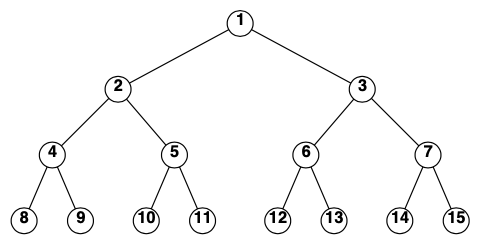

Initial state이 1이며 goal state은 11일때, 1) breadth-first search, 2)  limit이 3 인 depth-limited search, 3) iterative deepening search을 실행했을 때 방문하게 되는 노드 번호를 각 탐색 알고리즘마다 작성하시오.

1) breadth-first search
- 1 2 3 4 5 6 7 8 9

2) limit 3인 depth-limited search
- 1 2 4 8 9 5 10 11

3) iterative deepening search
- 깊이 0: 1
- 깊이 1: 1 2 3
- 깊이 2: 1 2 4 5 3 6 7
- 깊이 3: 1 2 4 8 9 5 10 11

### 3번

GridProblem의 `d6`, `d7` 그리드에 1) `greedy_bfs`, 2) `astar_search`, 3) `weighted_astar_search` with weight `1.4`, 4) `weighted_astar_search` with weight `2`을 적용하여 탐색의 결과를 출력하시오. 출력된 결과를 바탕으로 각 알고리즘의 optimality와 reached state의 크기를 비교분석하시오.

1) greedy_bfs
- d6

Greedy BFS search: 133.9 path cost

758 states reached

- d7

Greedy BFS search: 151.6 path cost

830 states reached

Optimality: 최적의 경로를 보장하지는 않음. 휴리스틱 값을 최소치로하는 경로를 선택하기 때문에 완벽하게 최적의 경로가 아닐 수 있음.

Reached: 상대적으로 다른 알고리즘에 비해 작을 수 있음. 목표에 빠르게 도달하기 위해 많은 경로 탐색이 발생하지 않을 수 있음.

---
2) astar_search

- d6

A* search search: 124.1 path cost

3,305 states reached

- d7

A* search search: 127.4 path cost

4,058 states reached


Optimality: 휴리스틱을 사용하여 intial과 goal state의 추정 비용을 통해 최적화를 진행함. greedy에 비해 이동 비용이 적은 것을 알 수 있음

Reached: greedy에 비해 최적 경로를 탐색하기 위한 더 많은 경로를 탐색함. 따라서 Reached의 크기가 커짐


---
3) weighted_astar_search with weight 1.4

- d6

weighted_astar_search search: 124.1 path cost

44,261 states reached

- d7

weighted_astar_search search: 127.4 path cost

46,506 states reached

4) weighted_astar_search with weight 2

- d6

weighted_astar_search search: 124.1 path cost

44,261 states reached

- d7

weighted_astar_search search: 127.4 path cost

46,506 states reached

Optimality: 가중치를 적용해 휴리스틱을 사용하며 greedy에 비해 더 적은 경로 비용을 가지고 있음

Reached: 가중치에 따라 빠르게 목표에 도달하려고 함. 그러나 많은 경로를 탐색하기 때문에 Reached state의 크기가 셋 중에 가장 큼




### 4번

In [ ]:
class EightPuzzle(Problem):
    """ The problem of sliding tiles numbered from 1 to 8 on a 3x3 board,
    where one of the squares is a blank, trying to reach a goal configuration.
    A board state is represented as a tuple of length 9, where the element at index i
    represents the tile number at index i, or 0 if for the empty square, e.g. the goal:
        1 2 3
        4 5 6 ==> (1, 2, 3, 4, 5, 6, 7, 8, 0)
        7 8 _
    """

    def __init__(self, initial, goal=(0, 1, 2, 3, 4, 5, 6, 7, 8)):
        assert inversions(initial) % 2 == inversions(goal) % 2 # Parity check
        self.initial, self.goal = initial, goal

    def actions(self, state):
        """The indexes of the squares that the blank can move to."""
        moves = ((1, 3),    (0, 2, 4),    (1, 5),
                 (0, 4, 6), (1, 3, 5, 7), (2, 4, 8),
                 (3, 7),    (4, 6, 8),    (7, 5))
        blank = state.index(0)
        return moves[blank]

    def result(self, state, action):
        """Swap the blank with the square numbered `action`."""
        s = list(state)
        blank = state.index(0)
        s[action], s[blank] = s[blank], s[action]
        return tuple(s)

    def h1(self, node):
        """The misplaced tiles heuristic."""
        return misplaced_tiles_heuristic(node.state, self.goal)

    def h2(self, node):
        """The Manhattan heuristic."""
        return manhattan_distance_heuristic(node.state, self.goal)

    def h(self, node): return EightPuzzle.h1(self, node)


def inversions(board):
    "The number of times a piece is a smaller number than a following piece."
    return sum((a > b and a != 0 and b != 0) for (a, b) in combinations(board, 2))


def board8(board, fmt=(3 * '{} {} {}\n')):
    "A string representing an 8-puzzle board"
    return fmt.format(*board).replace('0', '_')

class Board(defaultdict):
    empty = '.'
    off = '#'
    def __init__(self, board=None, width=8, height=8, to_move=None, **kwds):
        if board is not None:
            self.update(board)
            self.width, self.height = (board.width, board.height)
        else:
            self.width, self.height = (width, height)
        self.to_move = to_move

    def __missing__(self, key):
        x, y = key
        if x < 0 or x >= self.width or y < 0 or y >= self.height:
            return self.off
        else:
            return self.empty

    def __repr__(self):
        def row(y): return ' '.join(self[x, y] for x in range(self.width))
        return '\n'.join(row(y) for y in range(self.height))

    def __hash__(self):
        return hash(tuple(sorted(self.items()))) + hash(self.to_move)

: 

In [ ]:
e1 = EightPuzzle((1, 4, 2, 0, 7, 5, 3, 6, 8))
e2 = EightPuzzle((1, 2, 3, 4, 5, 6, 7, 8, 0))
e3 = EightPuzzle((4, 0, 2, 5, 1, 3, 7, 8, 6))
e4 = EightPuzzle((7, 2, 4, 5, 0, 6, 8, 3, 1))
e5 = EightPuzzle((8, 6, 7, 2, 5, 4, 3, 0, 1))

: 

In [ ]:
print(board8(e1.initial))

: 

1) 아래의 `misplaced_tiles_heuristic와` `manhattan_distance_heuristic` 함수들을 구현하고 간단한 documentation을 작성하시오. 작성된 test를 통해 구현 코드가 올바른지 확인하시오.

*   `misplaced_tiles_heuristic(A, B)`: 잘못 배치된 타일의 수(공백 미포함)
*   `manhattan_distance_heuristic(A, B)`: 타일의 목표 위치로부터의 거리의 합. 타일은 대각선을 따라 이동할 수 없기 때문에 거리는 가로 및 세로 거리의 합이다.



In [ ]:
def misplaced_tiles_heuristic(A, B):
    cnt = 0
    for x, y in zip(A, B):
      if x != y and x != 0:
        cnt += 1
    return cnt

: 

In [ ]:
def manhattan_distance_heuristic(A, B):
    def cal_dis(x, y):
      cur_row, cur_col = divmod(x, 3)
      goal_row, goal_col = divmod(y, 3)
      return abs(cur_row - goal_row) + abs(cur_col - goal_col)

    distance = [cal_dis(A.index(a), B.index(a)) for a in A if a != 0]
    return sum(distance)

: 

misplaced_tiles_heuristic:

A: current state of puzzle

B: goal state of puzzle

Return: current와 goal의 위치가 다르거나 공백인 상태, 즉 잘못 배치된 타일의 수를 반환

zip(A,B)를 이용해 현재 state와 goal state를 받아오고, 잘못 배치되었을때, cnt를 하나씩 늘림


---
manhattan_distance_heuristic:

A: current state of puzzle

B: goal state of puzzle

Return: 목표 위치로부터 거리의 합, 대각선x, 가로 세로만 이동가능한 거리의 합

공백이 아닌 current state의 값을 받아 3으로 나눠 current와 goal의 행과 열의 위치를 받음, 두 값을 계산해 거리를 알아내고 합한 다음 return함


In [ ]:
# test case
node1 = Node(e3.initial)
assert e3.h1(node1) == 7
assert e3.h2(node1) == 11

node2 = Node(e4.initial)
assert e4.h1(node2) == 8
assert e4.h2(node2) == 18

: 

2) 아래 알고리즘을 `e1`, `e2`, `e3`, `e4`, `e5` 보드에 적용하고 그 결과를 `report` 함수를 통해 출력하시오.

*   breadth_first_search: h = 0
*   A* search with misplaced tiles heuristic
*   A* search with Manhattan distance heuristic

특정 heuristic이 적용된 탐색 알고리즘 함수 생성 예시:

  ```
  def astar_misplaced_tiles(problem):
      return astar_search(problem, h=problem.h1)
  ```

In [ ]:
def astar_misplaced_tiles(problem):
  return astar_search(problem, h=problem.h1)

def astar_manhattan_distance(problem):
  return astar_search(problem, h=problem.h2)

: 

In [ ]:
problems = [e1, e2, e3, e4, e5]
searchers = [breadth_first_search, astar_misplaced_tiles, astar_manhattan_distance]

report(searchers, problems)

: 

3) 위 문제에서 출력된 결과를 바탕으로 uninformed search와 informed search의 차이와 각 heuristic의 차이를 알고리즘의 특성에 기반하여 비교분석하시오.

Uninformed search와 informed search:

uninformed search는 goal state에 도달하는데 정보가 없어 가능한 모든 경로를 탐색함. 따라서 탐색을 해나가는 과정에서 최적화된 경로로 이동하지 않을 수 있고, 불필요한 탐색이 발생할 수도 있음
breadth-first-search가 나머지 두 탐색에 비해 더 많은 노드와 action이 발생한 것으로 알 수 있음.


informed search는 휴리스틱을 사용하여 탐색을 진행하기 때문에 uninformed search에 비해 최적화된 탐색이 가능함. A*search의 탐색 노드 값과 action의 수는 uninformed search에 비해 적은 값을 보임

misplaced tiles heuristic은 current state에서 잘못된 위치를 계산하는 것. 최적화된 계산을 휴리스틱하게 도와주지만 goal state에 도달하기 위한 과정상의 거리와 같은 방식이 아님

manhattan distance heuristic은 goal state로 이동하기 위한 최소한의 거리를 계속 찾기 때문에 최적화에 좋음. 결과를 보면 이 휴리스틱이 misplaced heuristic에 비해 더 적은 노드를 탐색하고 action역시 적게 발생함. 따라서 현재 위치를 기반한 계산보다, 목표 위치로 이동하기 위한 이동 횟수 휴리스틱이 더 효율적임.
